In [11]:
from modelCPMWeight import numoflinks
import modelCPMWeight
numofparts = modelCPMWeight.numofparts -1 
from cython.heatmap import putGaussianMaps
from cython.pafmap import putVecMaps
from pprint import pprint
img_train_size = 368
part2ours = [9,8,7,10,11,12,-1,14,-1,13,3,2,1,4,5,6]

In [12]:
def padimg(img,destsize):
    import cv2
    import numpy as np
    s = img.shape
#    print img.shape,destsize/s[1],destsize/s[1]

    if(s[0] > s[1]):
        img_d = cv2.resize(img,dsize = None,fx = 1.0 * destsize/s[0], fy = 1.0 * destsize/s[0])
        img_temp = np.ones(shape = (destsize,destsize,3),dtype=np.uint8) * 128
        sd = img_d.shape
        img_temp[0:sd[0],0:sd[1],0:sd[2]]=img_d
    else:
        img_d = cv2.resize(img,dsize = None,fx = 1.0 * destsize/s[1],fy = 1.0 * destsize/s[1])
        img_temp = np.ones(shape = (destsize,destsize,3),dtype=np.uint8) * 128 
        sd = img_d.shape
        img_temp[0:sd[0],0:sd[1],0:sd[2]]=img_d
    return img_temp


In [13]:
def map2Ai(one_rect,fscale):
    one_person = np.zeros(shape = (numofparts,2))
    for onePoint in one_rect['annopoints']:
        x,y,part_id,isVisible = onePoint
        x *= fscale
        y *= fscale
        part_id = part2ours[part_id] -1 
        if part_id <= -1:
            continue
        one_person[part_id][0] = x 
        one_person[part_id][1] = y 
    return one_person
def genMask(oneimg,fscale):
    img = cv2.imread(oneimg['img_path'])
    mask = np.zeros(shape = (368,368),dtype = np.int32)
    for one_rect in oneimg['annoations']:
        one_person = map2Ai(one_rect,fscale)
        x0 = int(min(one_person,key = lambda x:x[0])[0])
        x1 = int(max(one_person,key = lambda x:x[0])[0])        
        y0 = int(min(one_person,key = lambda x:x[1])[1])
        y1 = int(max(one_person,key = lambda x:x[1])[1])
        print x0,x1,y0,y1
        pprint(one_rect)
        mask[y0:y1,x0:x1] = 1
    return mask

In [14]:
def generateLabelMap(oneimg):

    ori_img = cv2.imread(oneimg['img_path'])
    ori_img_shape = ori_img.shape
    fscale = 368.0/max(ori_img_shape[0],ori_img_shape[1])
    img_pad = padimg(ori_img,368)
    thre = 0.5
    crop_size_width = 368
    crop_size_height = 368

    augmentcols = 368
    augmentrows = 368
    stride = 8
    grid_x = augmentcols / stride
    grid_y = augmentrows / stride
    sigma = 26.0
    #sigma = 10.0
    #sigma = 26.0
    
    heat_map = list()
    for i in range(numofparts+1):
        heat_map.append(np.zeros((img_train_size, img_train_size)))


    for one_rect in oneimg['annoations']:
        for onePoint in one_rect['annopoints']:
            x,y,part_id,isVisible = onePoint
            x *= fscale
            y *= fscale
            x = int(x)
            y = int(y)
            part_id = part2ours[part_id]-1
            if part_id <= -1:
                continue
            cv2.circle(heat_map[part_id],(x,y),8,(1,1,1),-1,8)
            # putGaussianMaps(heat_map[part_id], 368, 368, 
            #                 x,y,
            #                 stride, grid_x, grid_y, sigma)
       
    ### put background channel
    #heat_map[numofparts] = heat_map[0]
    heat_map[numofparts] = np.max(heat_map[:-1],axis=0)
    # for g_y in range(heat_map[0].shape[0]):
    #     for g_x in range(heat_map[0].shape[1]):
    #         maximum=0
    #         for i in range(numofparts):
    #             if maximum<heat_map[i][g_y, g_x]:
    #                 maximum = heat_map[i][g_y, g_x]
    #         heat_map[numofparts][g_y,g_x]=max(maximum,0.0)
    

    mid_1 = [13,14,14,1, 2, 4, 5, 1, 7, 8, 4, 10, 11]
    mid_2 = [14,1,  4,2, 3, 5, 6, 7, 8, 9, 10,11, 12]
    thre = 1

    pag_map = list()
    for i in range(numoflinks*2):
        pag_map.append(np.zeros((46, 46)))

    count = np.zeros((46, 46))

    for one_rect in oneimg['annoations']:
        one_person = map2Ai(one_rect,fscale)
        for i in range(numoflinks):
            putVecMaps(pag_map[2 * i], pag_map[2 * i + 1], count,
                       one_person[mid_1[i]-1][0], one_person[mid_1[i]-1][1], 
                       one_person[mid_2[i]-1][0], one_person[mid_2[i]-1][1],
                       stride, 46, 46, sigma, thre)
    for i in range(len(heat_map)):
        heat_map[i]= cv2.resize(heat_map[i],(46,46),interpolation=cv2.INTER_NEAREST)
    return img_pad,heat_map, pag_map,genMask(oneimg,fscale).astype(np.float32)

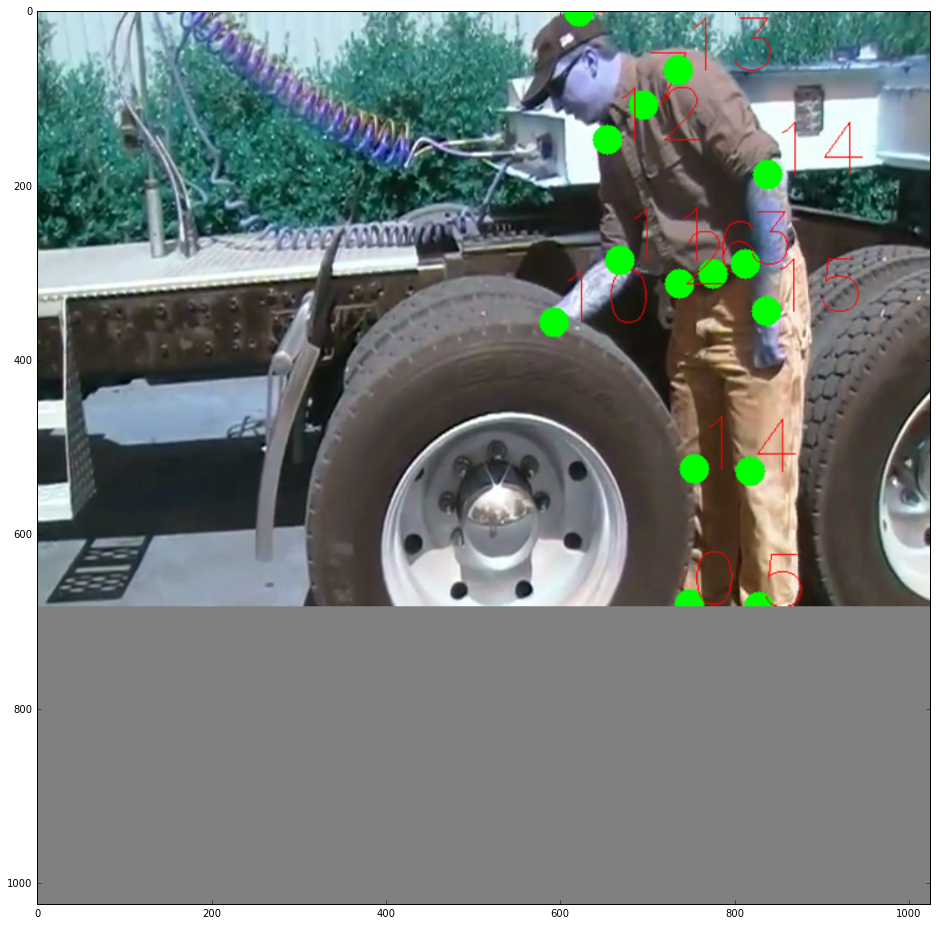

212 300 0 245
{u'annopoints': [[544, 212, 6, True],
                 [488, 76, 7, True],
                 [525, 478, 0, True],
                 [529, 369, 1, True],
                 [517, 220, 2, True],
                 [570, 204, 3, True],
                 [574, 371, 4, True],
                 [581, 480, 5, True],
                 [416, 251, 10, True],
                 [469, 201, 11, True],
                 [459, 104, 12, True],
                 [516, 48, 13, True],
                 [588, 132, 14, True],
                 [587, 242, 15, True],
                 [436, 1, 9, True]],
 u'scale': 2.8903812897263226,
 u'x1': 401,
 u'x2': 471,
 u'y1': 1,
 u'y2': 99}


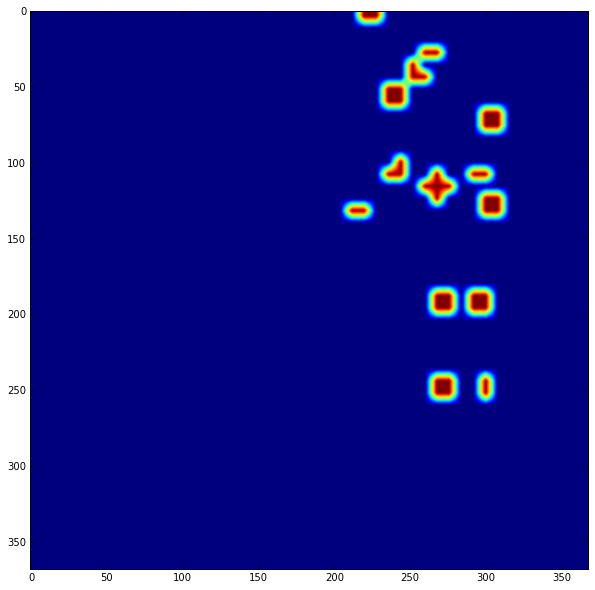

(0.0, 1.0)


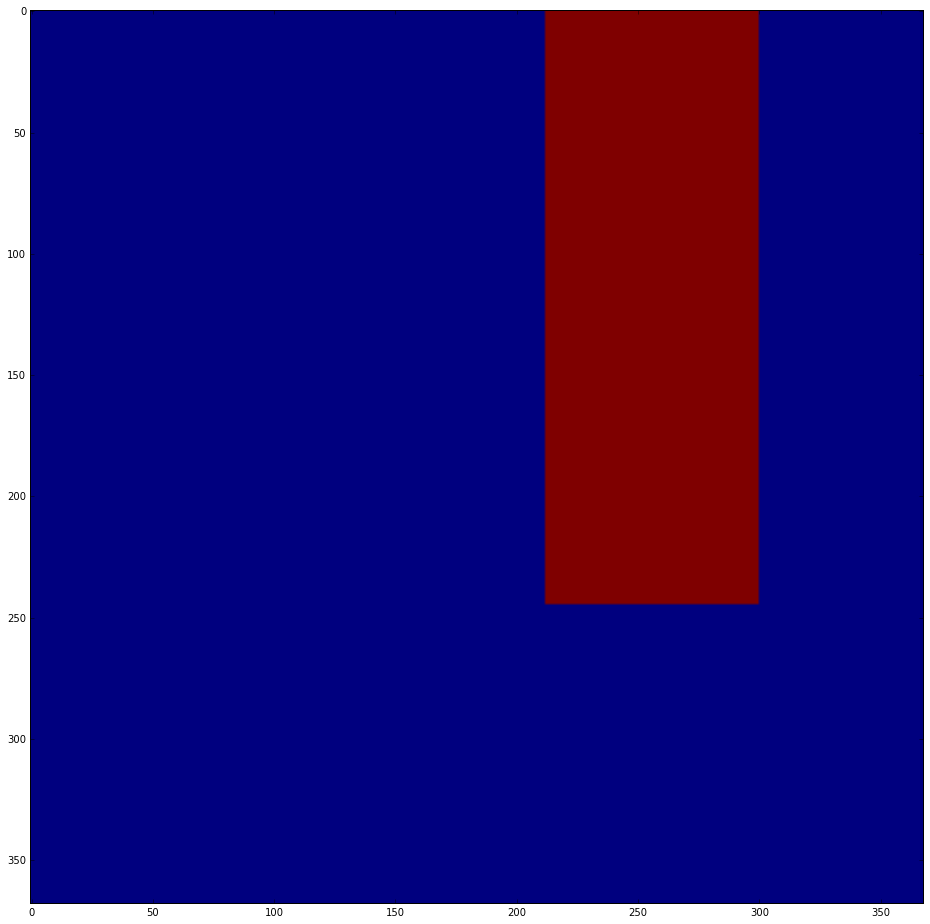

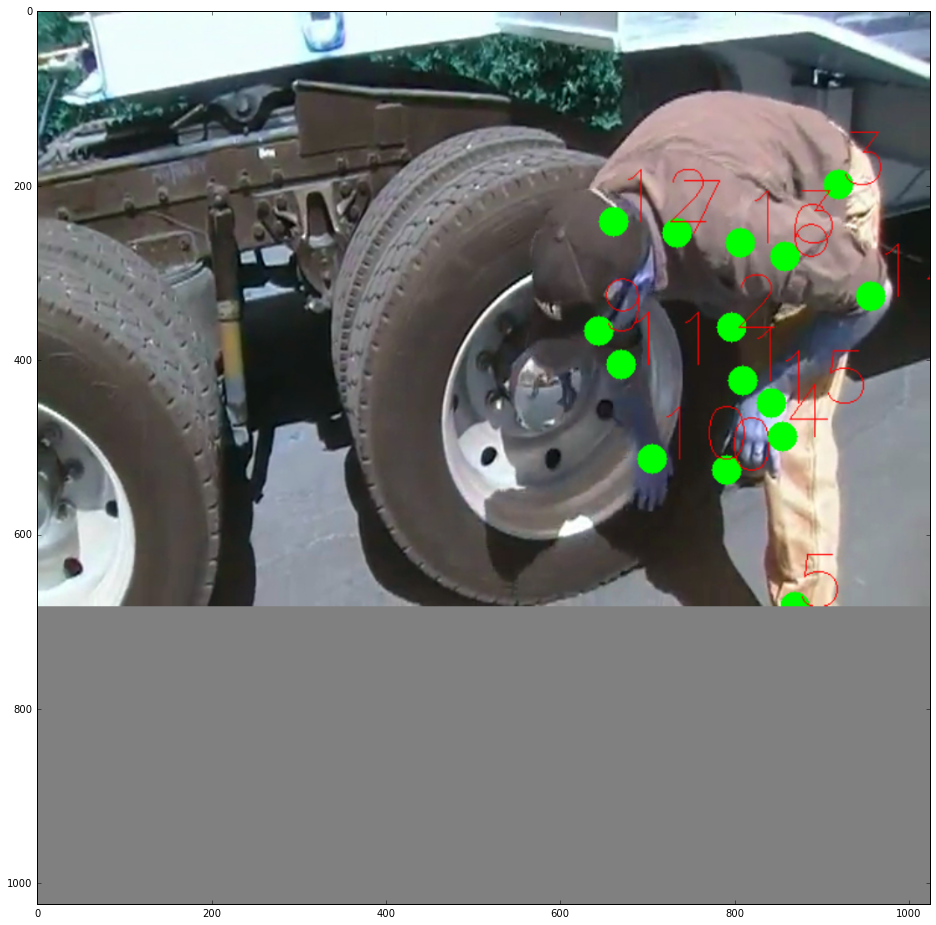

231 342 71 245
{u'annopoints': [[602, 198, 6, False],
                 [515, 179, 7, False],
                 [555, 370, 0, False],
                 [568, 298, 1, False],
                 [559, 255, 2, False],
                 [645, 140, 3, True],
                 [600, 343, 4, True],
                 [610, 480, 5, True],
                 [495, 361, 10, True],
                 [470, 285, 11, True],
                 [464, 170, 12, False],
                 [566, 187, 13, True],
                 [671, 230, 14, True],
                 [591, 316, 15, True],
                 [452, 258, 9, True]],
 u'scale': 3.5898256225059173,
 u'x1': 403,
 u'x2': 501,
 u'y1': 145,
 u'y2': 258}


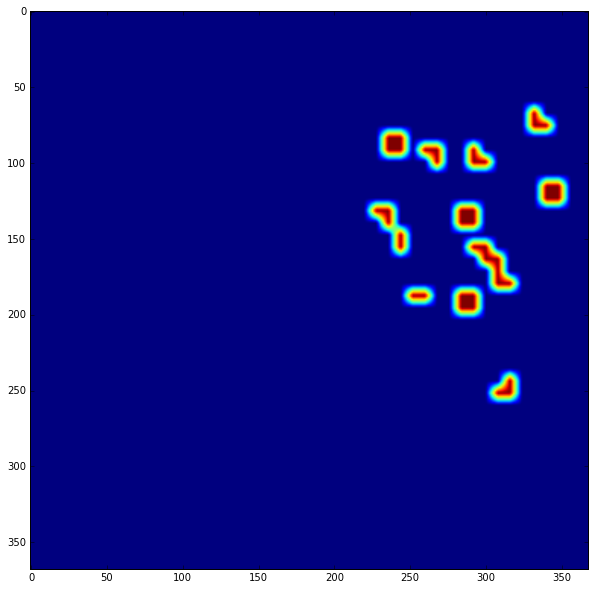

(0.0, 1.0)


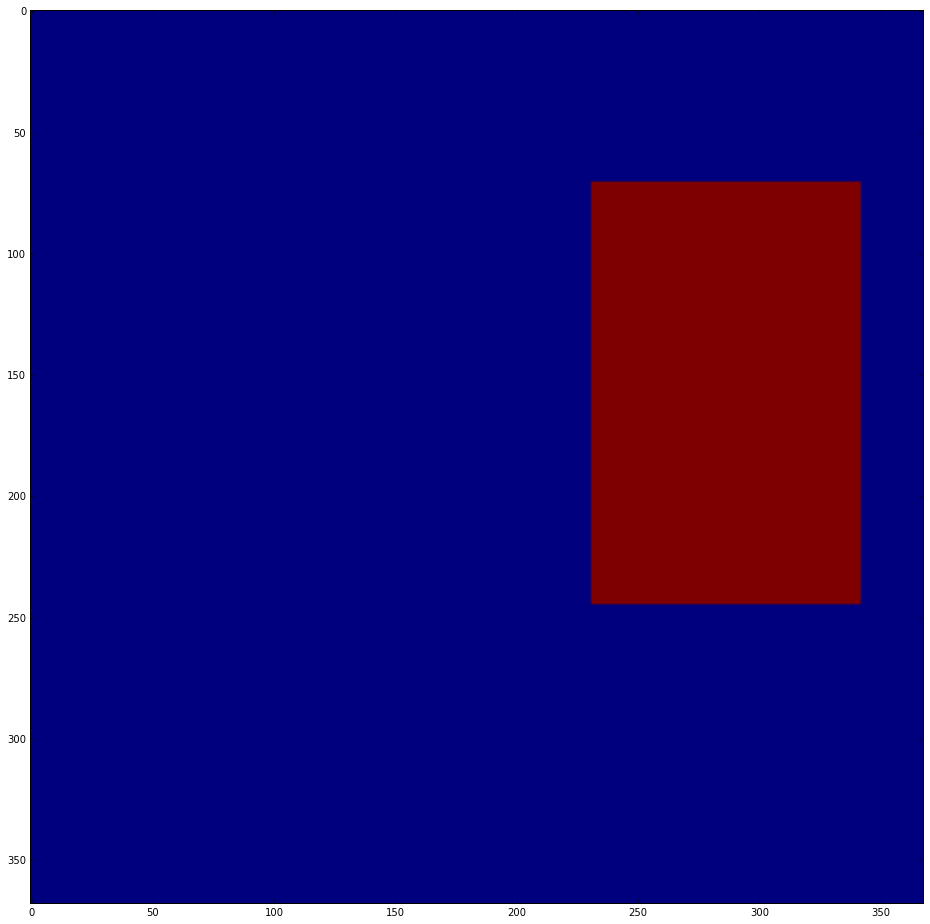

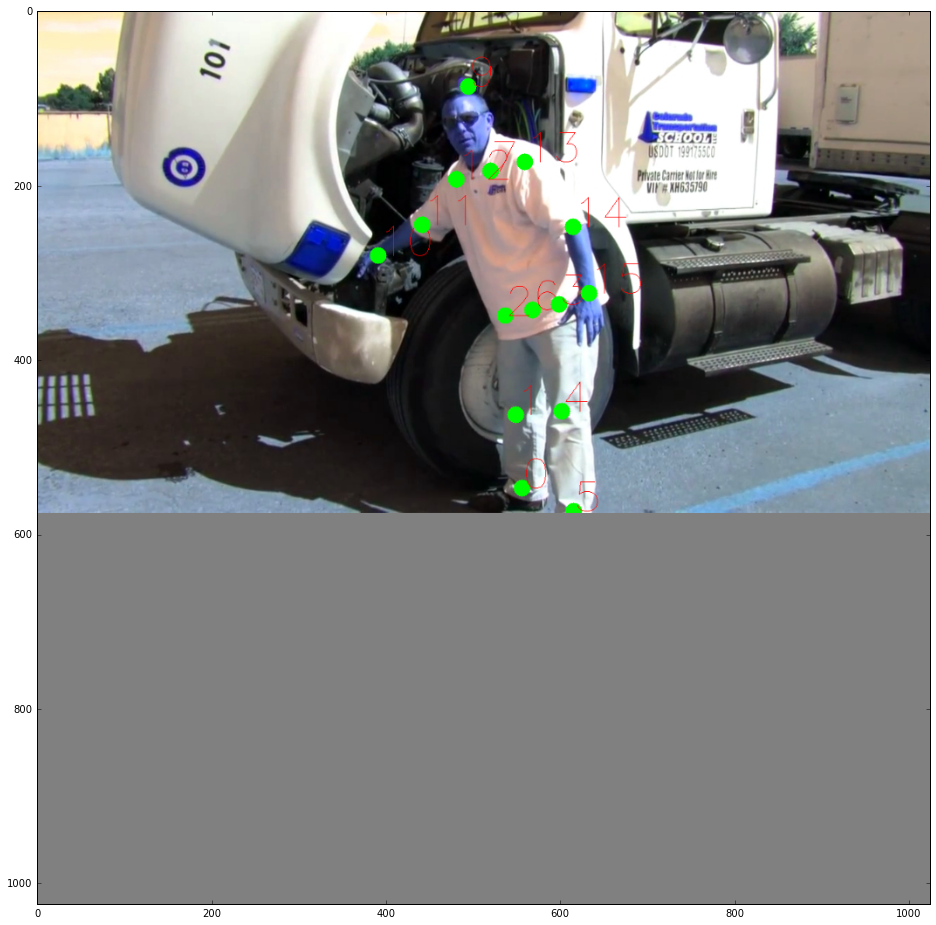

140 227 31 206
{u'annopoints': [[709, 429, 6, True],
                 [649, 230, 7, True],
                 [694, 684, 0, True],
                 [685, 579, 1, True],
                 [670, 437, 2, True],
                 [747, 421, 3, True],
                 [751, 574, 4, True],
                 [768, 717, 5, True],
                 [488, 351, 10, True],
                 [551, 307, 11, True],
                 [600, 242, 12, True],
                 [698, 217, 13, True],
                 [767, 310, 14, True],
                 [790, 405, 15, True],
                 [617, 109, 9, True]],
 u'scale': 3.3747959938342937,
 u'x1': 578,
 u'x2': 656,
 u'y1': 109,
 u'y2': 226}


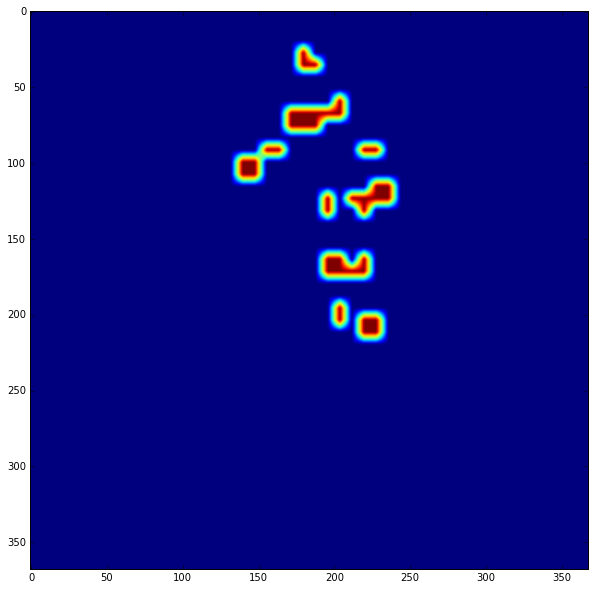

(0.0, 1.0)


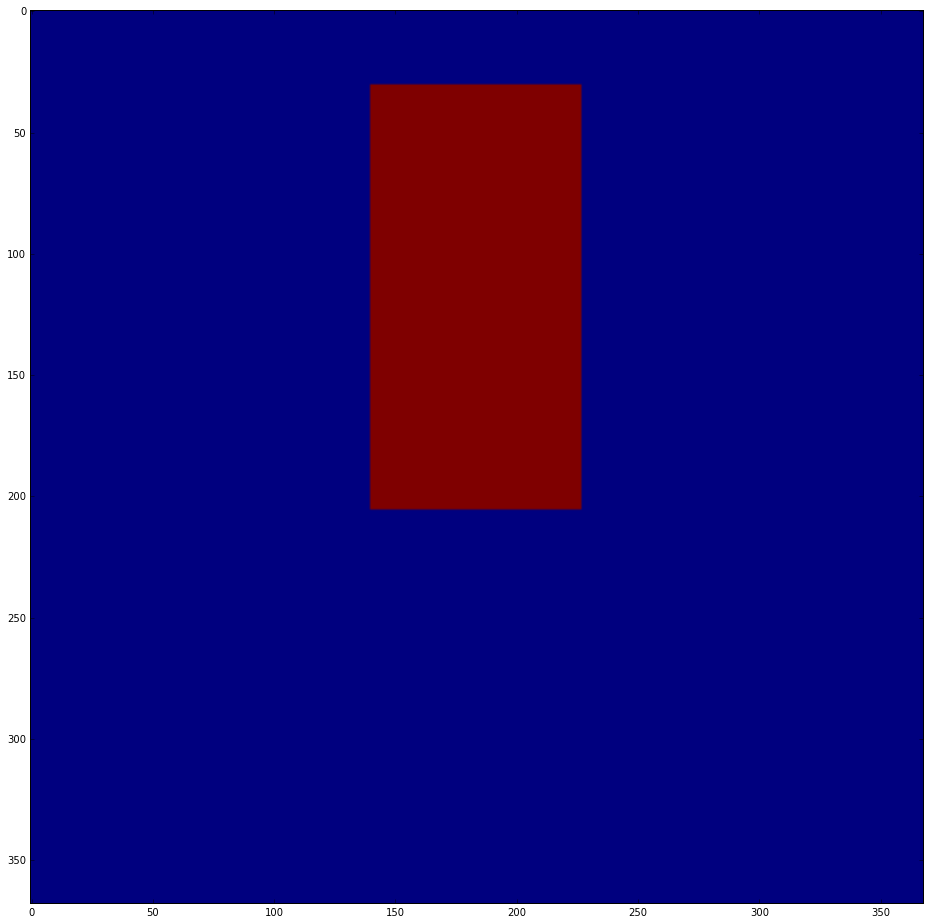

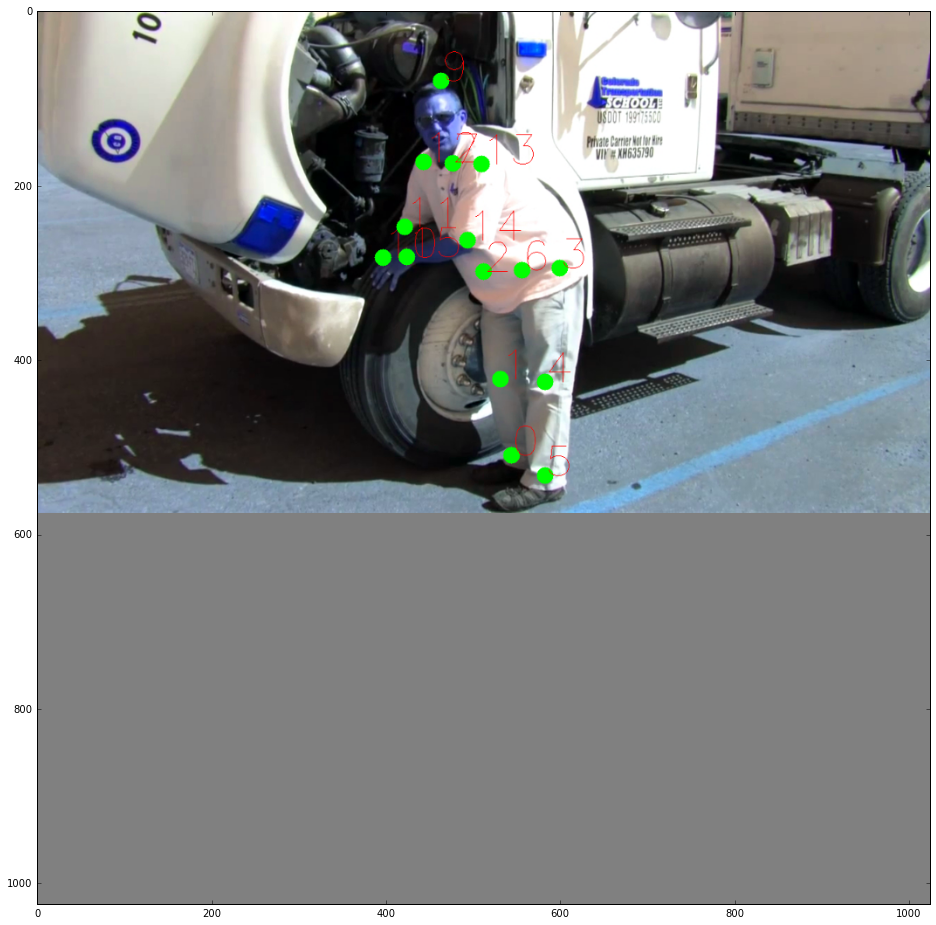

142 215 29 191
{u'annopoints': [[694, 372, 6, True],
                 [595, 219, 7, True],
                 [679, 637, 0, True],
                 [663, 528, 1, True],
                 [639, 374, 2, True],
                 [748, 369, 3, True],
                 [727, 532, 4, True],
                 [727, 666, 5, True],
                 [495, 354, 10, True],
                 [526, 310, 11, True],
                 [553, 217, 12, True],
                 [636, 220, 13, True],
                 [616, 329, 14, True],
                 [529, 353, 15, True],
                 [578, 101, 9, True]],
 u'scale': 3.3032929025443685,
 u'x1': 538,
 u'x2': 618,
 u'y1': 101,
 u'y2': 213}


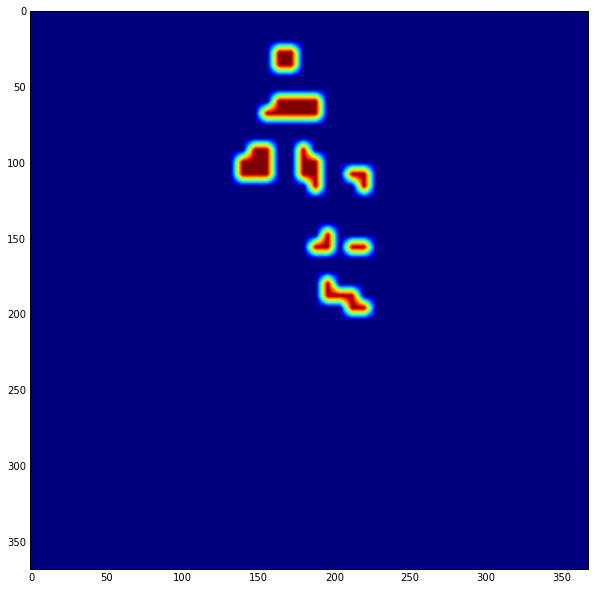

(0.0, 1.0)


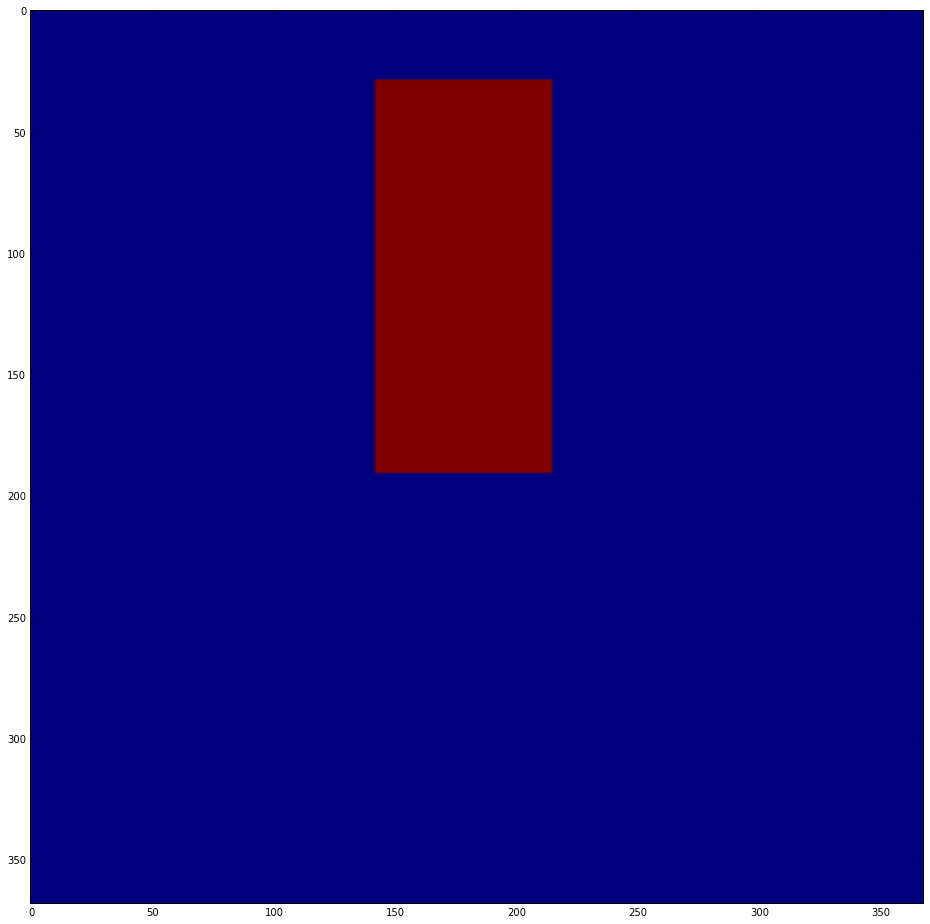

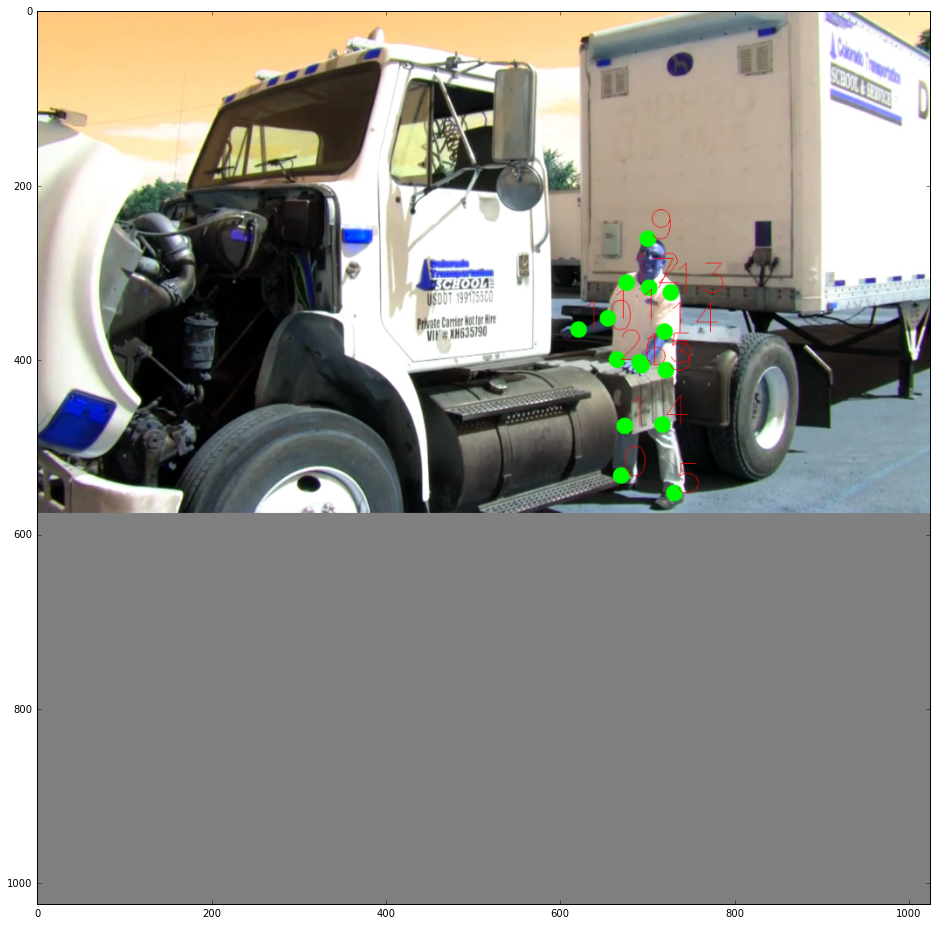

222 262 94 198
{u'annopoints': [[865, 508, 6, True],
                 [876, 397, 7, True],
                 [836, 666, 0, True],
                 [841, 595, 1, True],
                 [830, 500, 2, True],
                 [900, 515, 3, True],
                 [895, 593, 4, True],
                 [912, 691, 5, True],
                 [775, 457, 10, True],
                 [817, 441, 11, True],
                 [844, 390, 12, True],
                 [907, 404, 13, True],
                 [898, 460, 14, True],
                 [862, 504, 15, True],
                 [874, 327, 9, True]],
 u'scale': 1.9575821821829094,
 u'x1': 848,
 u'x2': 901,
 u'y1': 327,
 u'y2': 389}


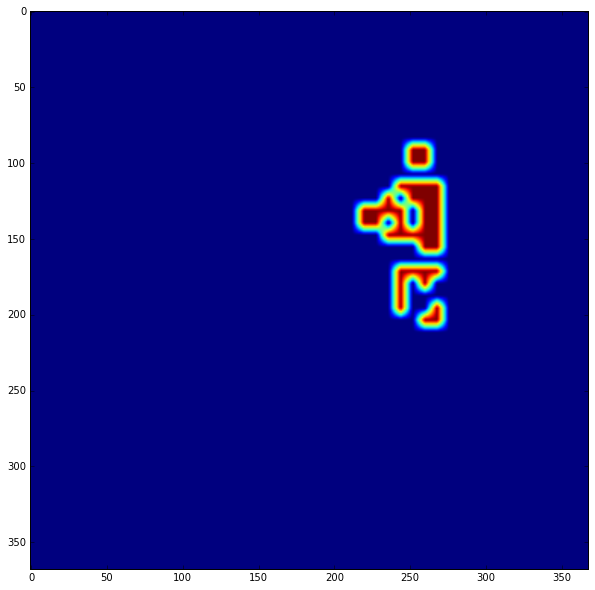

(0.0, 1.0)


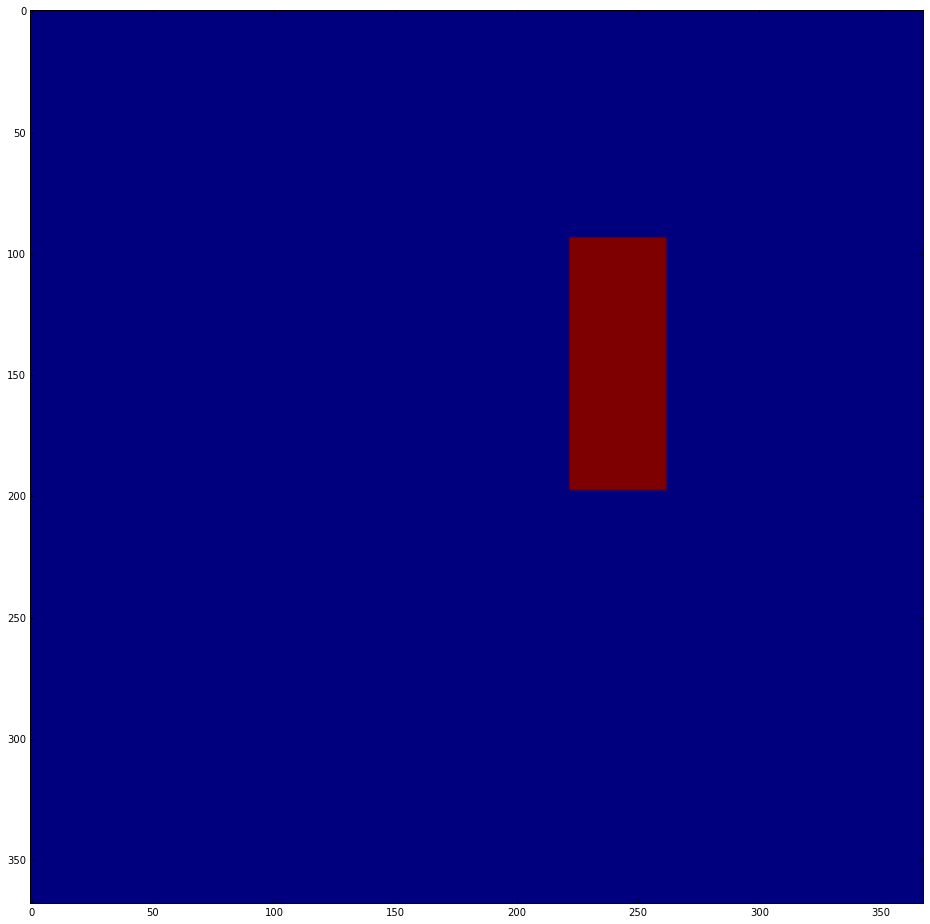

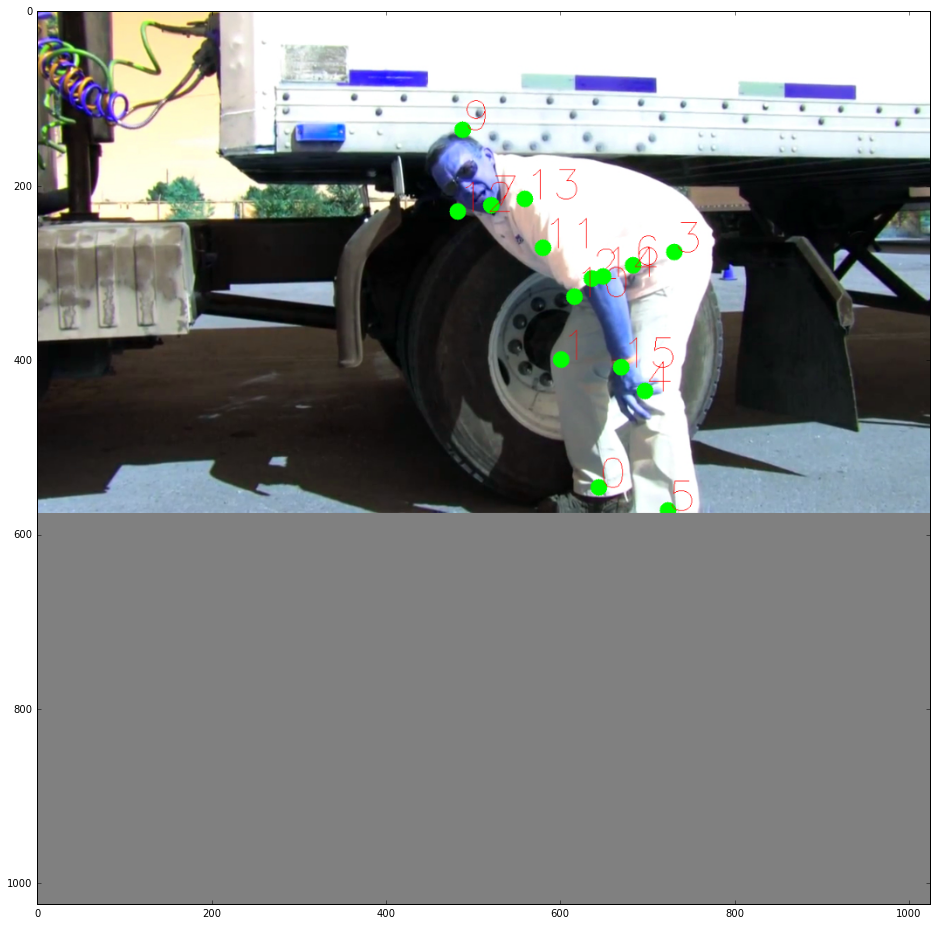

173 262 49 205
{u'annopoints': [[853, 365, 6, False],
                 [650, 279, 7, False],
                 [804, 683, 0, True],
                 [750, 500, 1, True],
                 [794, 384, 2, False],
                 [912, 346, 3, True],
                 [870, 545, 4, True],
                 [903, 716, 5, True],
                 [769, 410, 10, False],
                 [724, 340, 11, False],
                 [602, 288, 12, False],
                 [698, 270, 13, True],
                 [810, 381, 14, True],
                 [836, 511, 15, True],
                 [609, 171, 9, True]],
 u'scale': 4.076469060351128,
 u'x1': 552,
 u'x2': 667,
 u'y1': 171,
 u'y2': 296}


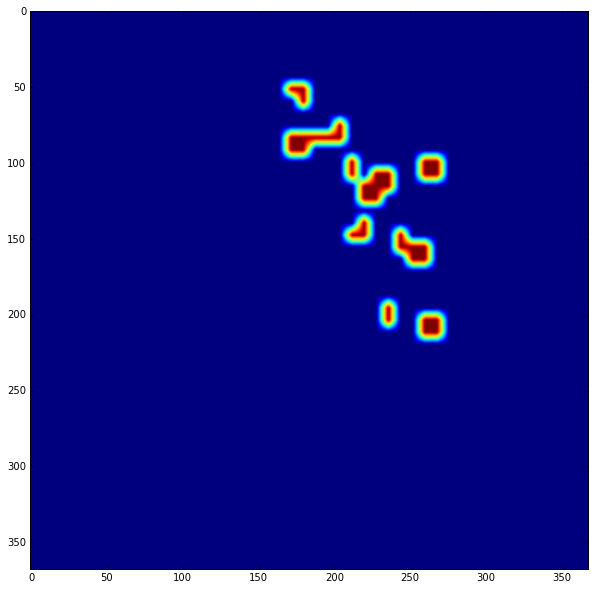

(0.0, 1.0)


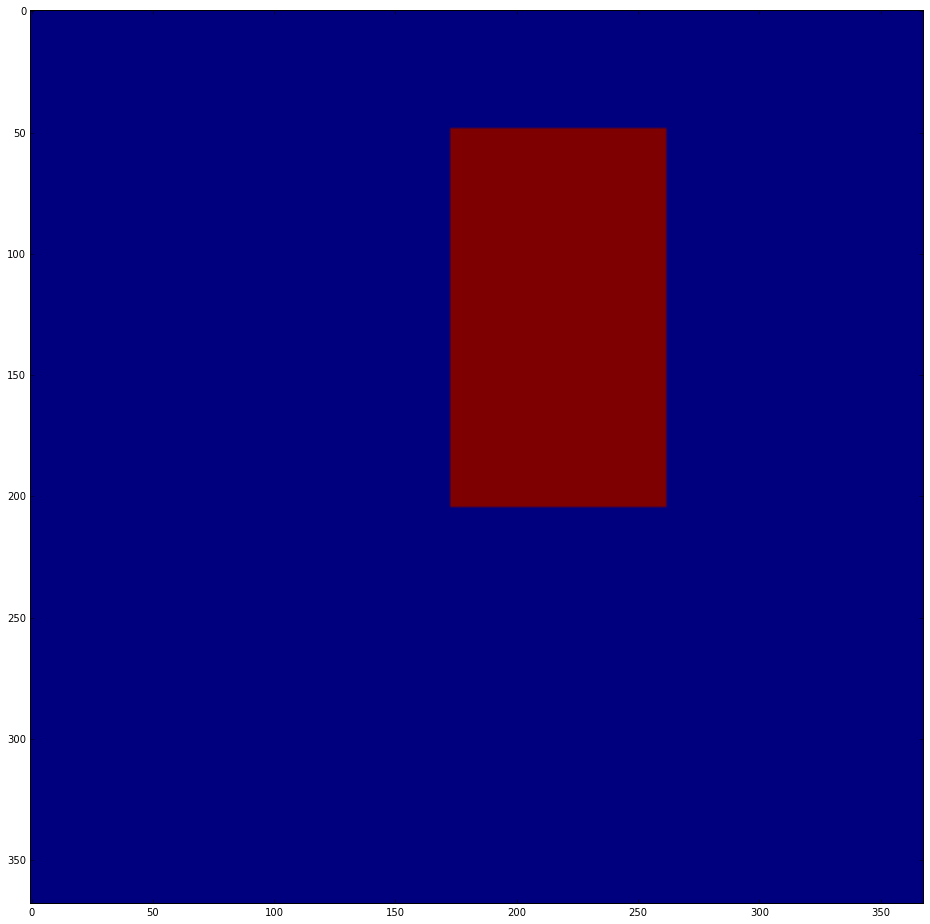

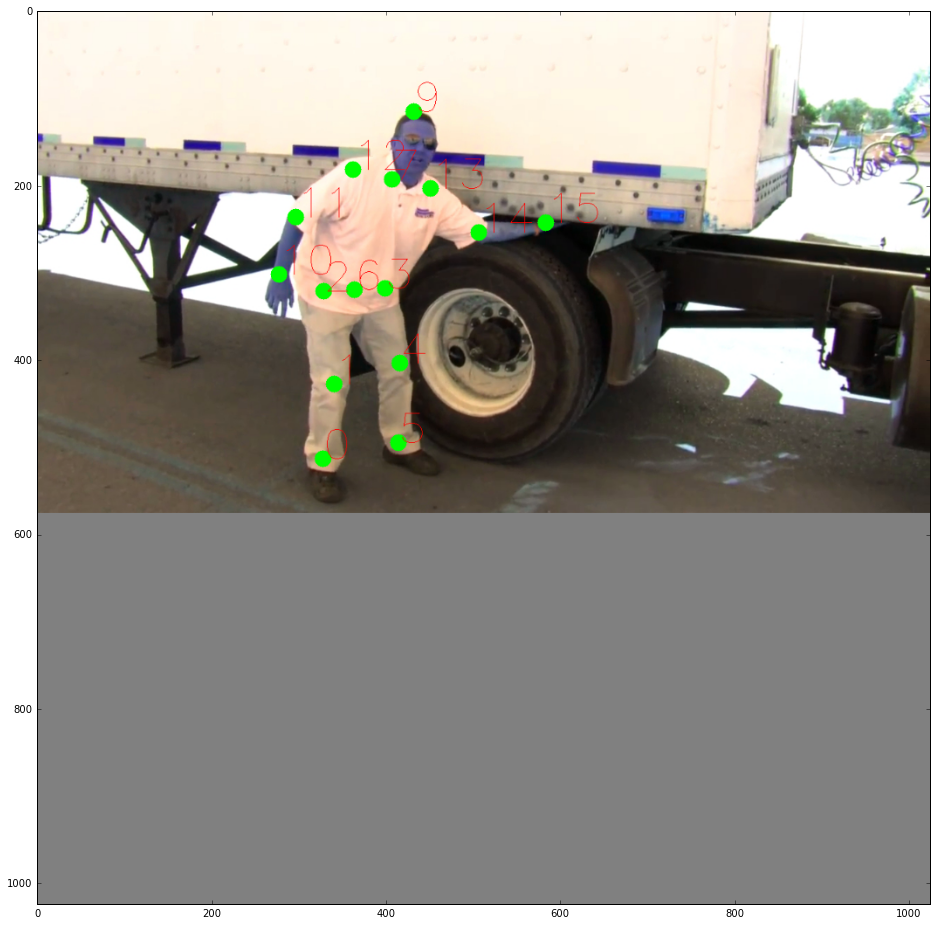

99 209 41 184
{u'annopoints': [[454, 400, 6, True],
                 [508, 242, 7, True],
                 [409, 642, 0, True],
                 [425, 535, 1, True],
                 [410, 402, 2, True],
                 [498, 398, 3, True],
                 [519, 505, 4, True],
                 [517, 619, 5, True],
                 [346, 378, 10, True],
                 [370, 296, 11, True],
                 [452, 228, 12, True],
                 [563, 255, 13, True],
                 [632, 318, 14, True],
                 [728, 304, 15, True],
                 [539, 145, 9, True]],
 u'scale': 2.8464040472146603,
 u'x1': 504,
 u'x2': 575,
 u'y1': 145,
 u'y2': 240}


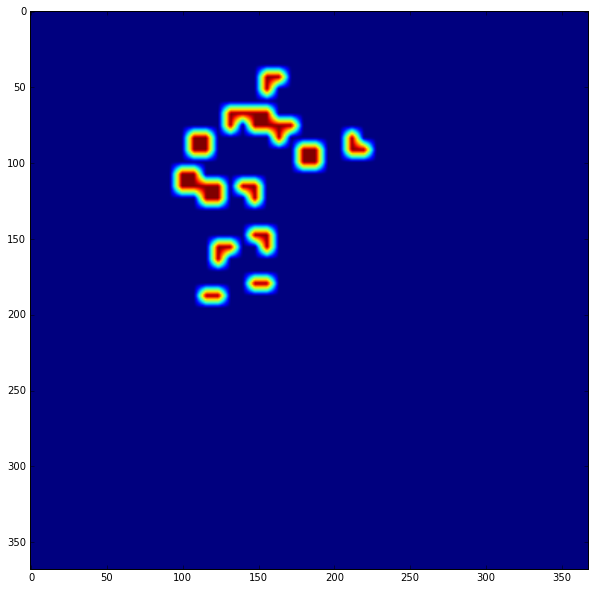

(0.0, 1.0)


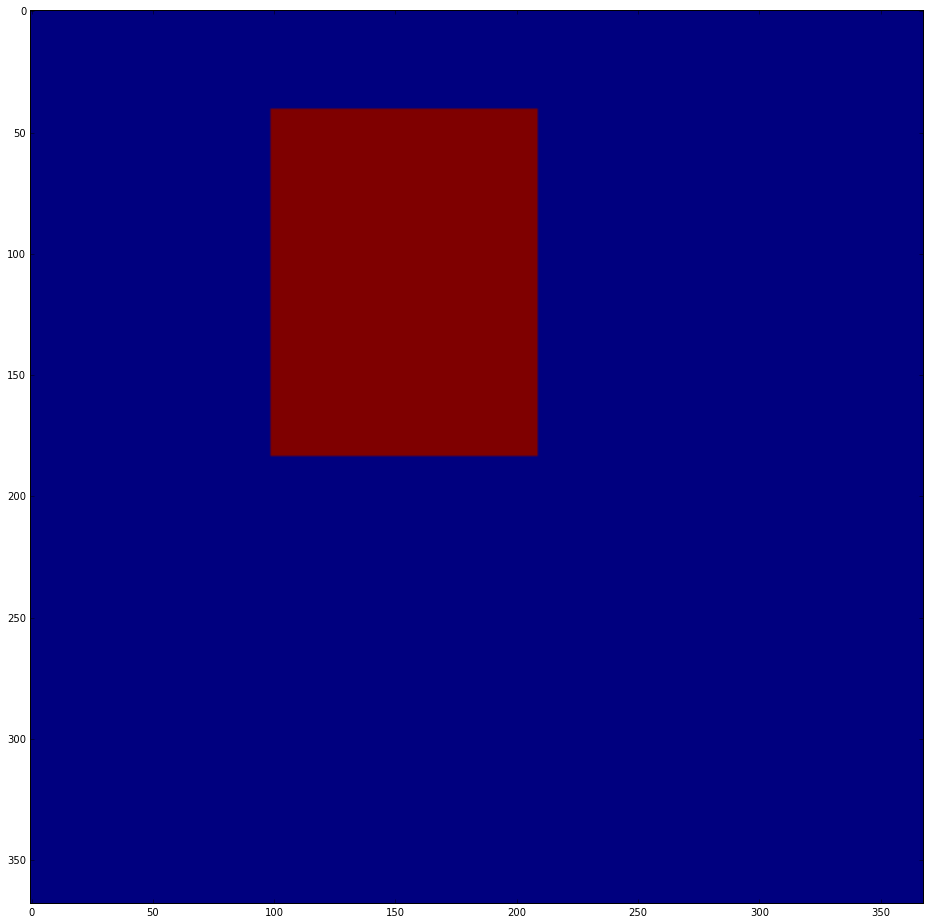

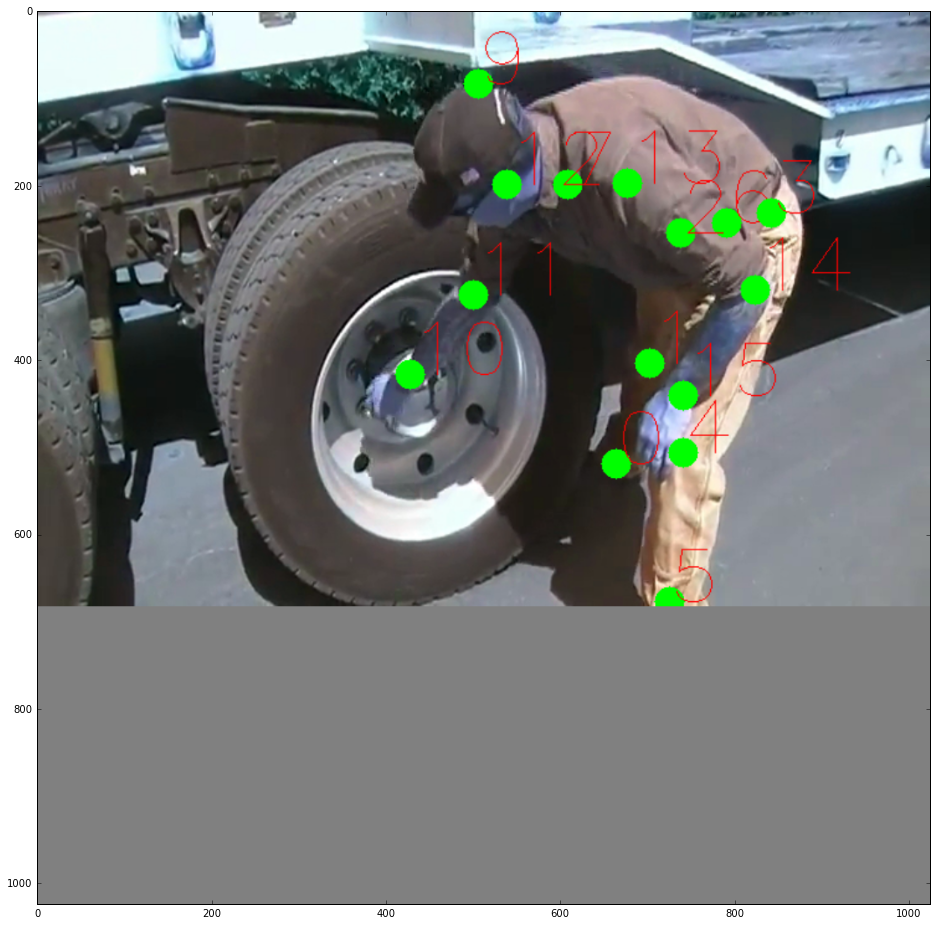

153 302 30 243
{u'annopoints': [[555, 171, 6, False],
                 [427, 140, 7, False],
                 [466, 365, 0, True],
                 [493, 284, 1, True],
                 [518, 179, 2, False],
                 [591, 163, 3, True],
                 [520, 356, 4, True],
                 [509, 476, 5, True],
                 [300, 293, 10, True],
                 [351, 229, 11, True],
                 [378, 140, 12, False],
                 [475, 139, 13, True],
                 [578, 225, 14, True],
                 [520, 310, 15, True],
                 [355, 59, 9, True]],
 u'scale': 3.840749926772115,
 u'x1': 302,
 u'x2': 409,
 u'y1': 59,
 u'y2': 178}


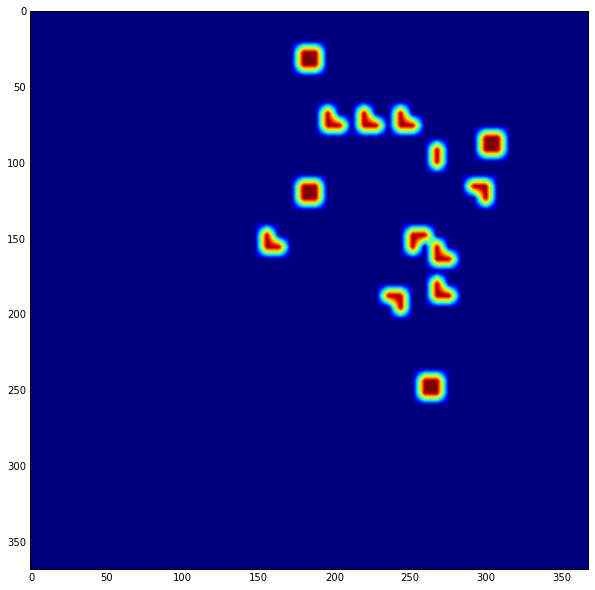

(0.0, 1.0)


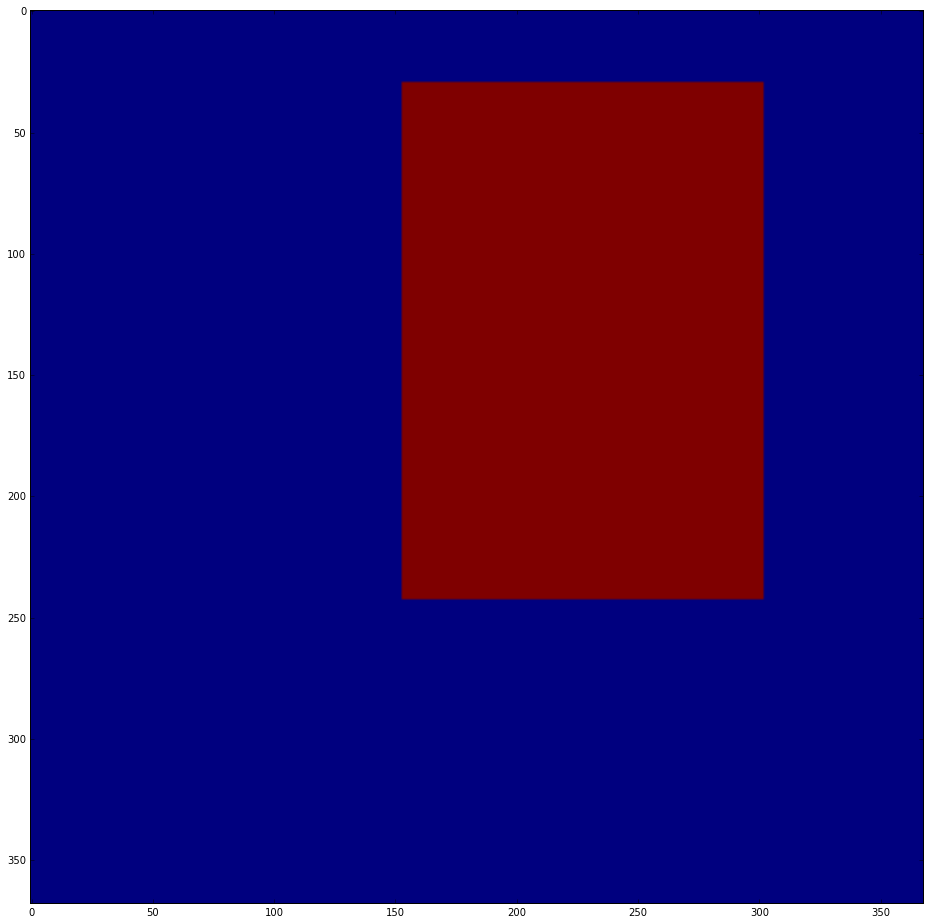

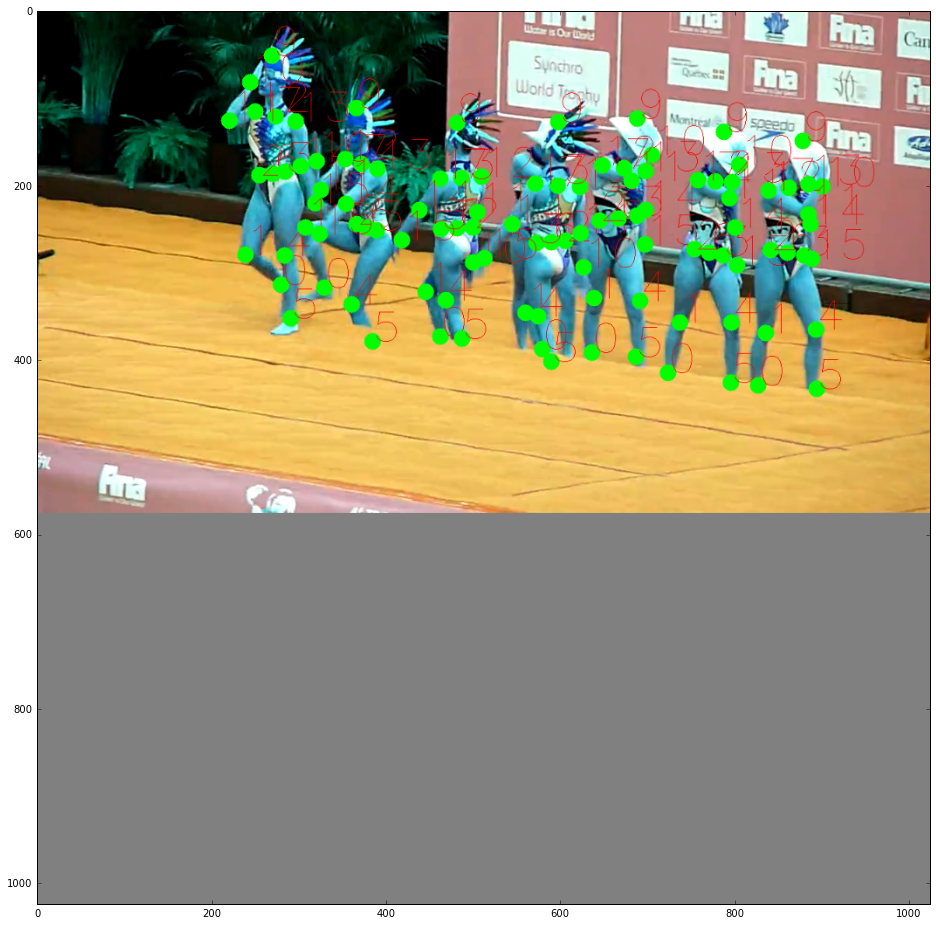

79 114 18 126
{u'annopoints': [[337, 234, 6, True],
                 [341, 152, 7, True],
                 [349, 393, 0, True],
                 [298, 350, 1, True],
                 [318, 236, 2, True],
                 [355, 231, 3, True],
                 [354, 351, 4, True],
                 [363, 441, 5, True],
                 [305, 103, 10, True],
                 [275, 158, 11, True],
                 [312, 145, 12, True],
                 [370, 159, 13, True],
                 [377, 223, 14, True],
                 [398, 276, 15, True],
                 [336, 65, 9, True]],
 u'scale': 1.9008545446719483,
 u'x1': 312,
 u'x2': 360,
 u'y1': 65,
 u'y2': 128}
110 140 40 136
{u'annopoints': [[472, 311, 6, True],
                 [464, 220, 7, True],
                 [411, 397, 0, True],
                 [384, 311, 1, True],
                 [457, 306, 2, True],
                 [486, 315, 3, True],
                 [450, 421, 4, True],
                 [480, 474, 5, False],
        

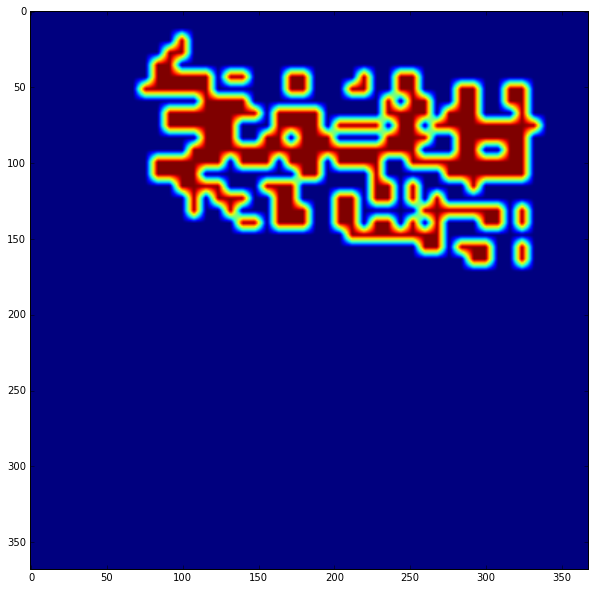

(0.0, 1.0)


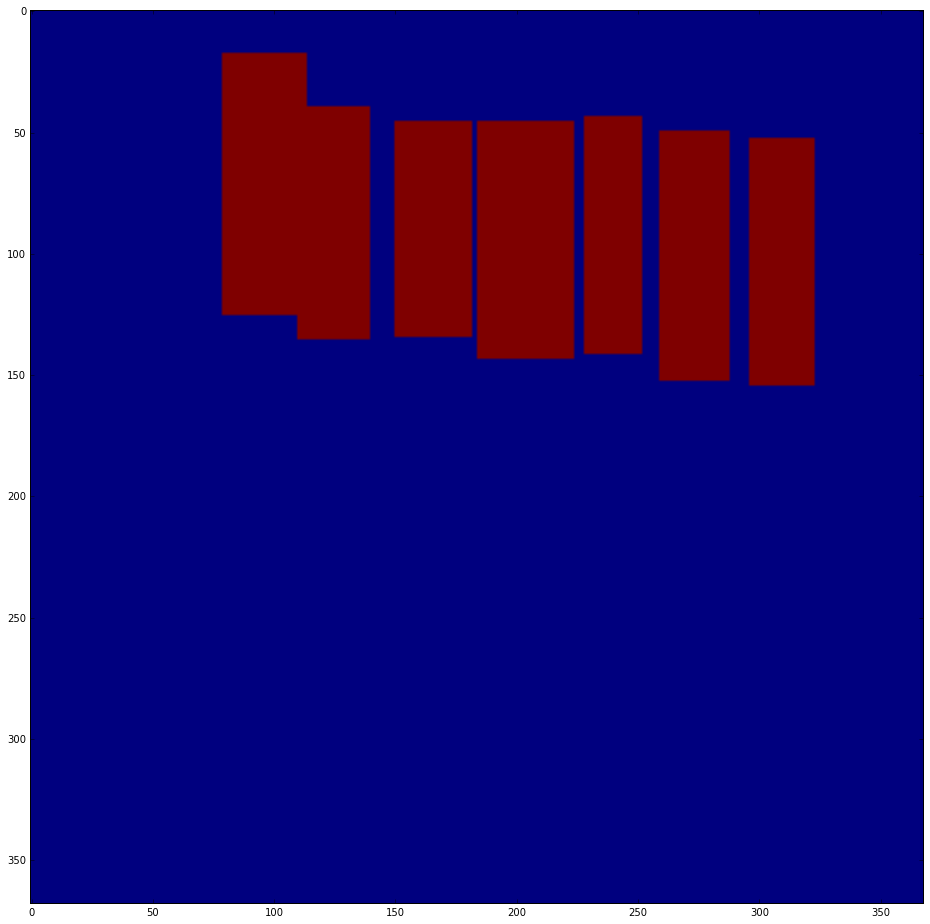

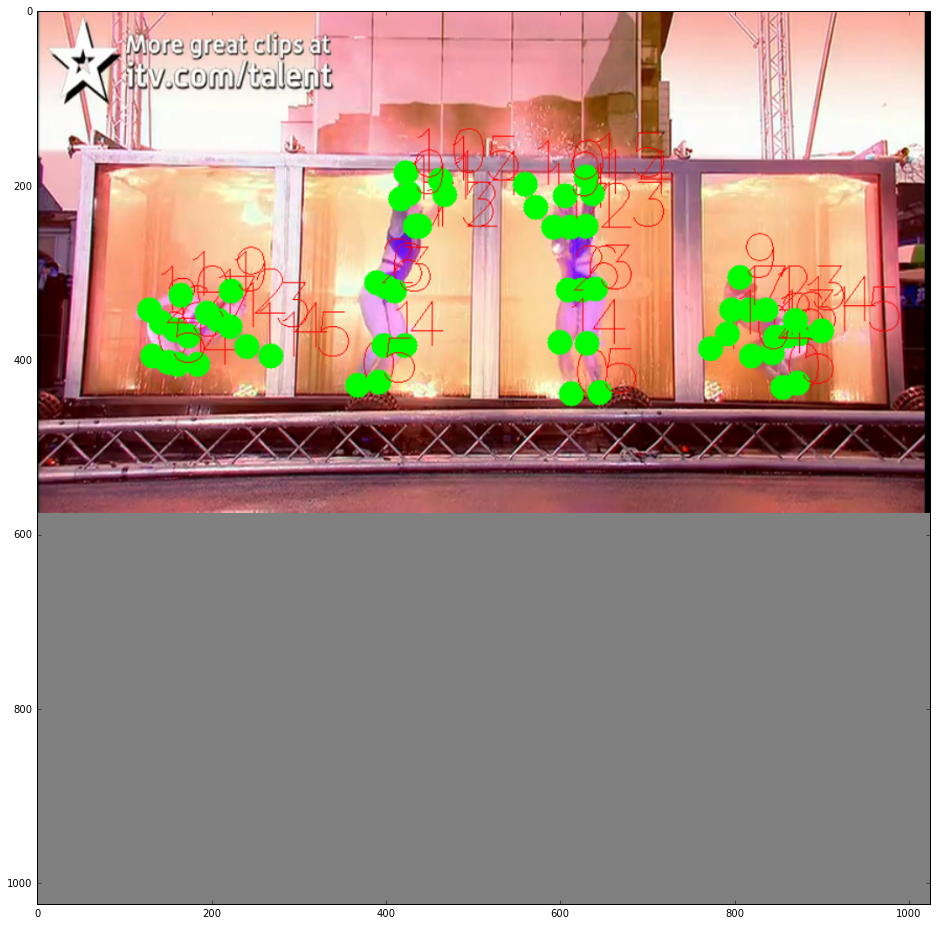

46 96 115 145
{u'annopoints': [[131, 305, 6, True],
                 [173, 296, 7, True],
                 [110, 330, 0, True],
                 [134, 338, 1, True],
                 [118, 298, 2, True],
                 [144, 311, 3, True],
                 [153, 338, 4, True],
                 [125, 336, 5, False],
                 [107, 286, 10, True],
                 [137, 272, 11, True],
                 [162, 289, 12, True],
                 [184, 302, 13, True],
                 [200, 321, 14, True],
                 [223, 330, 15, True],
                 [185, 268, 9, True]],
 u'scale': 1.0882352686804446,
 u'x1': 170,
 u'x2': 200,
 u'y1': 268,
 u'y2': 302}
131 167 66 154
{u'annopoints': [[333, 264, 6, True],
                 [363, 206, 7, True],
                 [306, 358, 0, True],
                 [331, 320, 1, True],
                 [324, 260, 2, True],
                 [341, 268, 3, True],
                 [351, 320, 4, True],
                 [326, 355, 5, True],
      

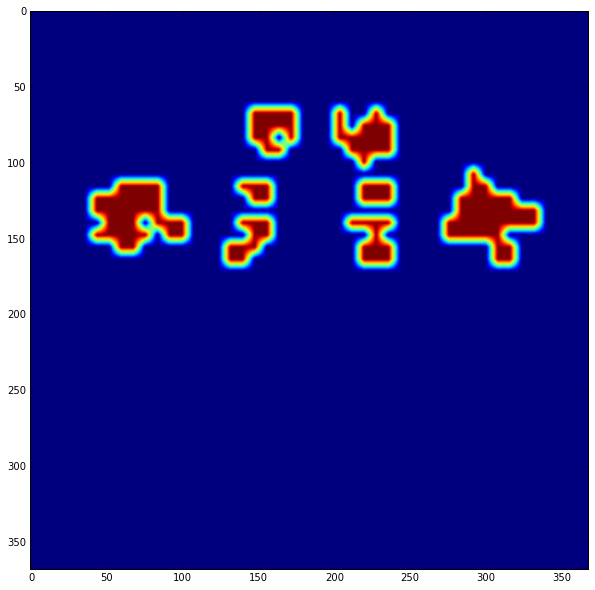

(0.0, 1.0)


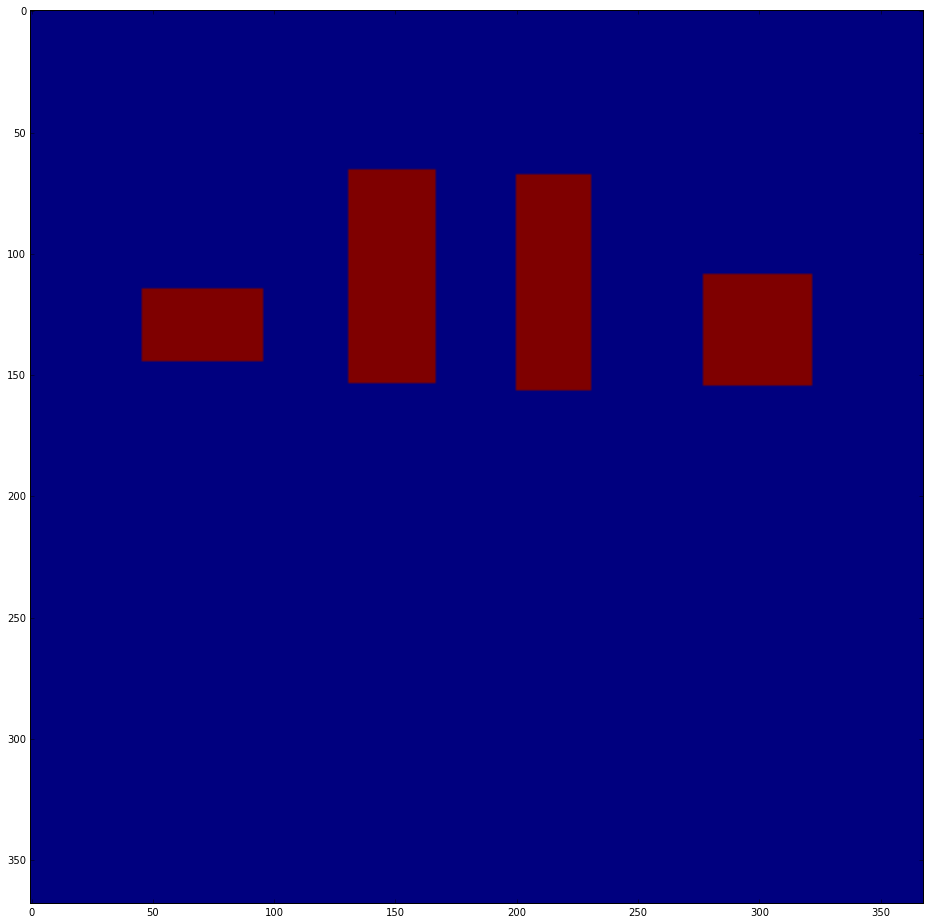

In [15]:
%matplotlib inline
import json,cv2,numpy as np,sys
import matplotlib.pyplot as plt
all_img = json.load(open("/data1/yks/dataset/openpose_dataset/mpi/a.json","rb"))
for oneimg in all_img[10:20]:
    img = cv2.imread(oneimg['img_path'])

    for one_rect in oneimg['annoations']:
        #cv2.rectangle(img,(one_rect['x1'],one_rect['y1']),(one_rect['x2'],one_rect['y2']),(0,255,255),-1,8)
        for point in one_rect['annopoints']:
            cv2.circle(img,(point[0],point[1]),12,(0,255,0),-1,8)
            cv2.putText(img, "{0}".format(point[2]), (point[0],point[1]), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,0));
    img = padimg(img,1024)
    fig = plt.gcf()
    fig.set_size_inches(16, 16)    
    plt.imshow(img)
    plt.show()

    img_pad,heat_map,pag_map,mask = generateLabelMap(oneimg)
    for heat in heat_map[14:15]:
        fig = plt.gcf()
        heat = cv2.resize(heat,(368,368))
        fig.set_size_inches(10, 10)    
        plt.imshow(np.uint8(heat* 255))
        plt.show()
        print(np.min(heat),np.max(heat))
    fig = plt.gcf() 
    fig.set_size_inches(16, 16)    
    plt.imshow(np.uint8(mask* 255))
    plt.show()
         